# Change point detection on PSD data

Sébastien MEYER, Adrienne TUYNMAN

First, you might want to run the notebook `download_seismic_data.ipynb`. This notebook allows you to download and prepare fine PSD values for performing change point detection.

In this notebook, we are going to evaluate different algorithms from the `ruptures` package for change point detection.

All the useful functions are already included in the source code.

In [1]:
from src.models.ppsd import load_ppsd, extract_ppsd_signal
from src.models.hub import fit_predict, evaluate, elbow_method, dp_bkps, p_bkps
from src.utils.data import replace_df, resample_df
from src.utils.plotting import plot_ppsd, plot_bkps, plot_elbow, plot_dp, plot_p, plot_nb

In [2]:
# These parameters are shared in the whole notebook
COST_NAME = "rbf"

MIN_FREQ = 4.0
MAX_FREQ = 14.0

## Load precomputed PSD data

We are going to load the PSD data as downloaded using default values in `download_seismic_data.ipynb`.

In [3]:
data_dir = "data"

start_date = "2020-01-01"
end_date = "2022-01-01"

ppsd_dfs = load_ppsd(
    data_dir=data_dir,
    start_date=start_date,
    end_date=end_date
)
ppsd_df = ppsd_dfs["FR.STR.00.BHZ"]

Converting PPSD to dataframe (FR.STR.00.BHZ): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.97s/it]


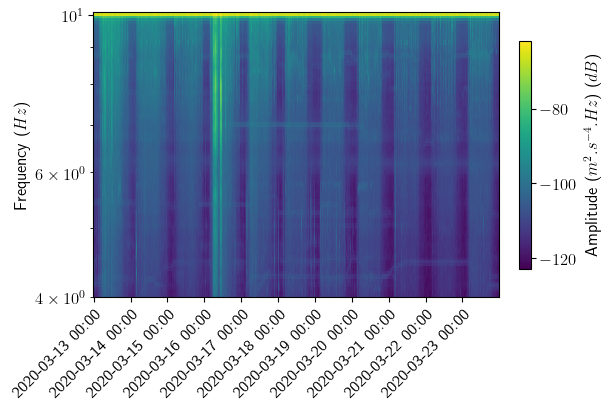

In [4]:
start_date_plot = "2020-03-13"
end_date_plot = "2020-03-23"

plot_ppsd(
    ppsd_df=ppsd_df,
    start_date_plot=start_date_plot,
    end_date_plot=end_date_plot,
    min_freq_plot=MIN_FREQ,
    max_freq_plot=MAX_FREQ,
    savefig=False
)

Replacing values: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 591/591 [00:14<00:00, 40.50it/s]


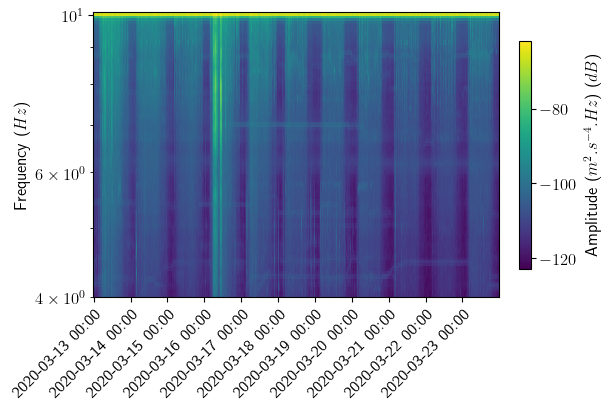

In [5]:
min_value = -500

ppsd_df = replace_df(
    df=ppsd_df,
    min_value=min_value
)

plot_ppsd(
    ppsd_df=ppsd_df,
    start_date_plot=start_date_plot,
    end_date_plot=end_date_plot,
    min_freq_plot=MIN_FREQ,
    max_freq_plot=MAX_FREQ,
    savefig=False
)

## A simple example: nationwide lockdown

We are interested in spotting the start and end dates of COVID lockdowns in France.

We can make a few remarks about the displacement:

- There are a few outliers at very specific points in time.
- There is more data (one sample every 15 minutes) than required for doing change point detection.

We choose to perform the following preprocessing, inspired from [Maciel et al.](https://github.com/sutaina/brasiliaNoise).

- Remove data between 7pm and 7am, as we do not expect much urban noise during this period.
- Resample data with a frequency of 1 day, taken as the median so as to be robust to outliers.

In [6]:
between_begin = "7:00"
between_end = "19:00"
freq = "1D"

ppsd_df_lkdwn = resample_df(
    df=ppsd_df,
    between_begin=between_begin,
    between_end=between_end,
    freq=freq
)

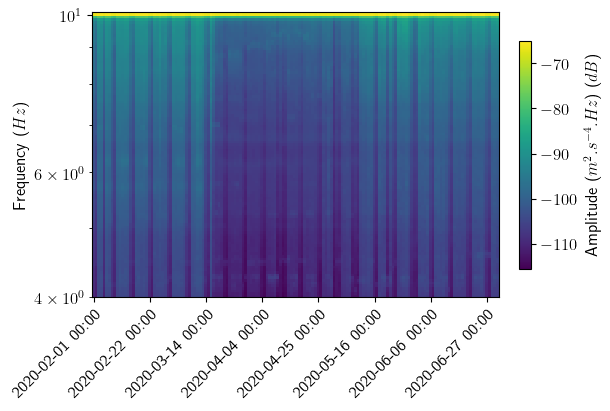

In [7]:
start_date_plot = "2020-02-01"
end_date_plot = "2020-07-01"

plot_ppsd(
    ppsd_df=ppsd_df_lkdwn,
    start_date_plot=start_date_plot,
    end_date_plot=end_date_plot,
    min_freq_plot=MIN_FREQ,
    max_freq_plot=MAX_FREQ,
    savefig=False
)

The data is already clearer for visualization. Now, we can proceed with change point detection. We already know the start and end dates of the nationwide lockdown that occurred in France.

- start of the lockdown: 15.03.2020 at 12pm
- end of the lockdown: 11.05.2020 at 12am

Let us use change point detection to detect this change. As we already know that 2 change points should occur, we can use the `Dynp` algorithm. 

In [8]:
start_date_signal = "2020-02-01"
end_date_signal = "2020-07-01"

important_dates = {
    "2020-03-15 12:00": "First nationwide lockdown starts",
    "2020-05-11 00:00": "First nationwide lockdown ends",
}

datelist, signal, true_bkps = extract_ppsd_signal(
    ppsd_df=ppsd_df_lkdwn,
    start_date_signal=start_date_signal,
    end_date_signal=end_date_signal,
    min_freq_signal=MIN_FREQ,
    max_freq_signal=MAX_FREQ,
    important_dates=list(important_dates.keys())
)

{'precision-recall': (1.0, 1.0), 'hausdorff': 2.0, 'randindex': 0.9826931567328918}


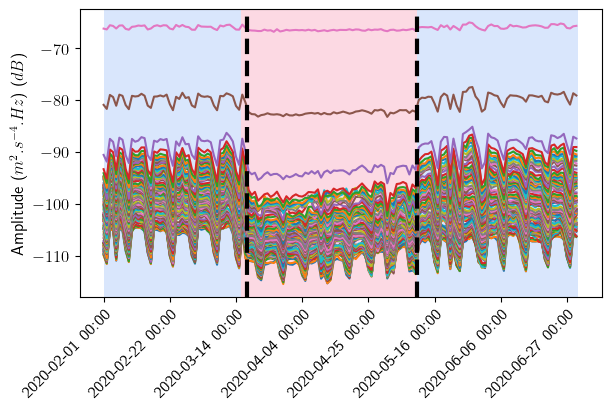

In [9]:
n_bkps = len(true_bkps) - 1

pred_bkps = fit_predict(
    signal=signal,
    cost_name=COST_NAME,
    n_bkps=n_bkps
)

results_scores = evaluate(
    true_bkps,
    pred_bkps
)
print(results_scores)

plot_bkps(
    signal=signal,
    true_bkps=true_bkps,
    pred_bkps=pred_bkps,
    datelist=datelist,
    savefig=False
)

Similar results to the 1D case.

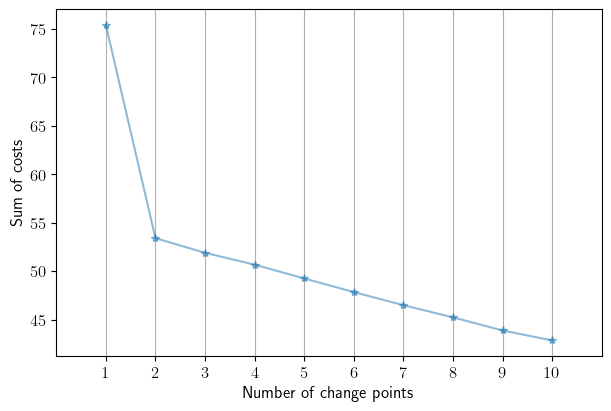

In [10]:
n_bkps_max = 10

array_of_n_bkps, array_of_costs = elbow_method(
    signal=signal,
    cost_name=COST_NAME,
    n_bkps_max=n_bkps_max
)

plot_elbow(
    array_of_n_bkps=array_of_n_bkps,
    array_of_costs=array_of_costs,
    savefig=False
)

{'precision-recall': (1.0, 1.0), 'hausdorff': 2.0, 'randindex': 0.9826931567328918}


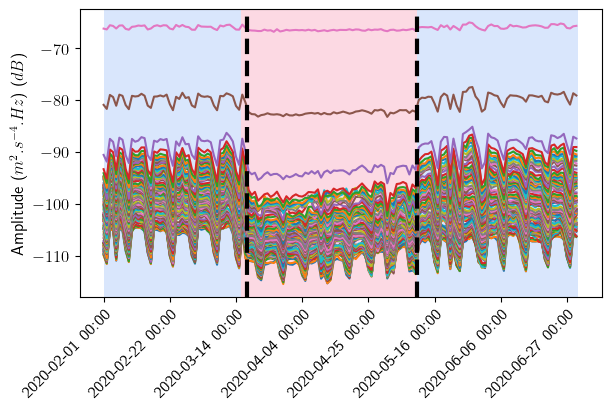

In [11]:
pen = 5

pred_bkps = fit_predict(
    signal=signal,
    cost_name=COST_NAME,
    pen=pen
)

results_scores = evaluate(
    true_bkps,
    pred_bkps
)
print(results_scores)

plot_bkps(
    signal=signal,
    true_bkps=true_bkps,
    pred_bkps=pred_bkps,
    datelist=datelist,
    savefig=False
)

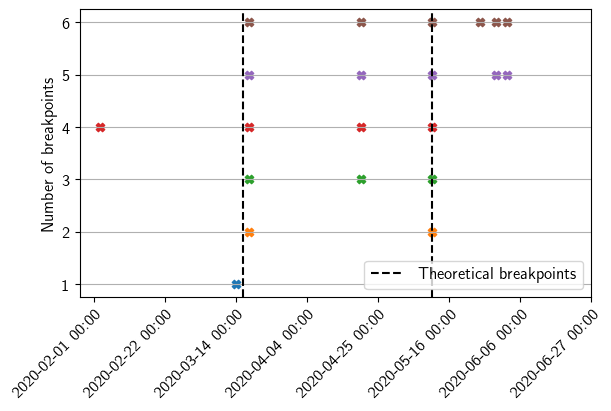

In [12]:
n_bkps_max = 6

array_of_n_bkps, list_of_bkps = dp_bkps(
    signal=signal,
    cost_name=COST_NAME,
    n_bkps_max=n_bkps_max
)

plot_dp(
    true_bkps,
    list_of_bkps,
    datelist=datelist,
    savefig=False
)

### Second nationwide lockdown

The second lockdown in France has the following important dates:

- start of the lockdown: 30.10.2020 at 12pm
- end of the lockdown: 15.12.2020 at 12am

However, this lockdown was less strict than the first one. Moreover, the end date of the lockdown is not clear. Indeed, many shops reopened on 15.12.2020, while universities and schools only reopened on 20.01.2021.

Let us use change point detection to detect this change. As we already know that 2 change points should occur, we can use the `Dynp` algorithm. 

In [13]:
start_date_signal = "2020-10-01"
end_date_signal = "2021-03-01"

important_dates = {
    "2020-10-30": "Second nationwide lockdown starts",
    "2020-12-16": "Second nationwide lockdown ends (curfew)",
    "2021-01-16": "Second nationwide lockdown ends (totally)",
}

datelist, signal, true_bkps = extract_ppsd_signal(
    ppsd_df=ppsd_df_lkdwn,
    start_date_signal=start_date_signal,
    end_date_signal=end_date_signal,
    min_freq_signal=MIN_FREQ,
    max_freq_signal=MAX_FREQ,
    important_dates=list(important_dates.keys())
)

{'precision-recall': (0.3333333333333333, 0.3333333333333333), 'hausdorff': 17.0, 'randindex': 0.8324944812362031}


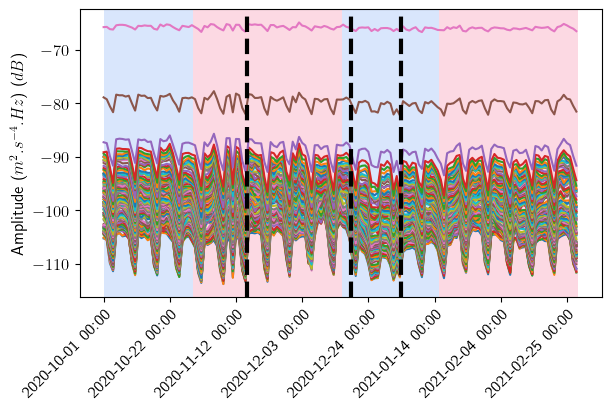

In [14]:
n_bkps = len(true_bkps) - 1

pred_bkps = fit_predict(
    signal=signal,
    cost_name=COST_NAME,
    n_bkps=n_bkps
)

results_scores = evaluate(
    true_bkps,
    pred_bkps
)
print(results_scores)

plot_bkps(
    signal=signal,
    true_bkps=true_bkps,
    pred_bkps=pred_bkps,
    datelist=datelist,
    savefig=False
)

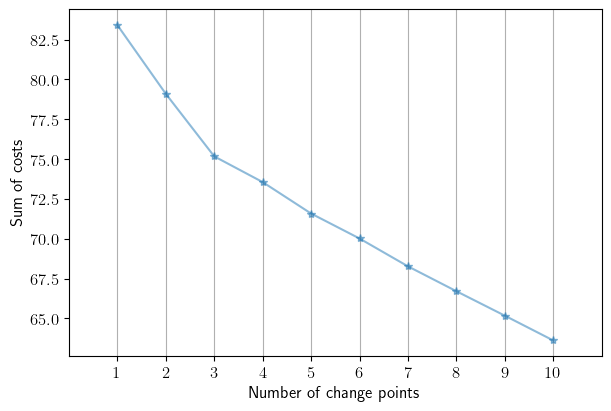

In [15]:
n_bkps_max = 10

array_of_n_bkps, array_of_costs = elbow_method(
    signal=signal,
    cost_name=COST_NAME,
    n_bkps_max=n_bkps_max
)

plot_elbow(
    array_of_n_bkps=array_of_n_bkps,
    array_of_costs=array_of_costs,
    savefig=False
)

{'precision-recall': (0.3333333333333333, 0.3333333333333333), 'hausdorff': 17.0, 'randindex': 0.8324944812362031}


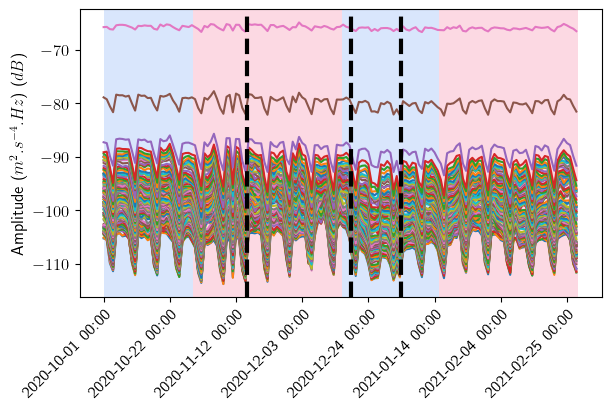

In [17]:
cost_name = "rbf"
# pen = 2
pen = 1.85  # yields better results!

pred_bkps = fit_predict(
    signal=signal,
    cost_name=cost_name,
    pen=pen
)

results_scores = evaluate(
    true_bkps,
    pred_bkps
)
print(results_scores)

plot_bkps(
    signal=signal,
    true_bkps=true_bkps,
    pred_bkps=pred_bkps,
    datelist=datelist,
    savefig=False
)

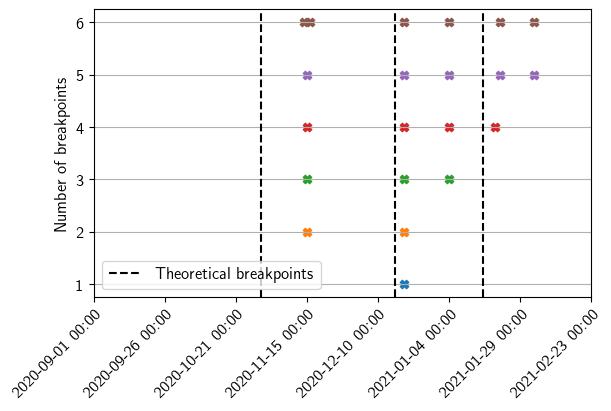

In [17]:
n_bkps_max = 6

array_of_n_bkps, list_of_bkps = dp_bkps(
    signal=signal,
    cost_name=COST_NAME,
    n_bkps_max=n_bkps_max
)

plot_dp(
    true_bkps,
    list_of_bkps,
    datelist=datelist,
    savefig=False
)

## Detailed analysis: curfews

We noticed that it is more difficult to predict the second nationwide lockdown, as it happened in multiple steps and was less strict than the first one.

We would like to perform a finer analysis of the data. Indeed, a curfew was enforced in October 17, 2020 and the final curfew only ended in June 20, 2021. During that time, the start time of the curfew changed many times.

We choose to perform the following preprocessing:

- Keep all available data.
- Resample data with frequency 1 hour, taken as the median to be robust to outliers.

In [18]:
freq = "1H"

ppsd_df_cfw = resample_df(
    df=ppsd_df,
    freq=freq
)

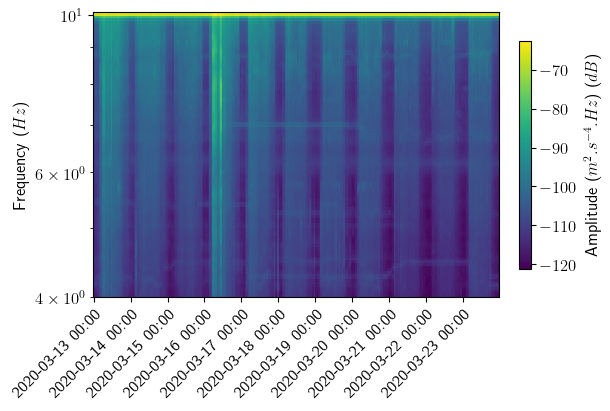

In [19]:
start_date_plot = "2020-03-13"
end_date_plot = "2020-03-23"

plot_ppsd(
    ppsd_df=ppsd_df_cfw,
    start_date_plot=start_date_plot,
    end_date_plot=end_date_plot,
    min_freq_plot=MIN_FREQ,
    max_freq_plot=MAX_FREQ,
    savefig=False
)

In [20]:
start_date_signal = "2020-10-01"
end_date_signal = "2021-07-14"

important_dates = {
    "2020-10-17": "Curfew 10pm-6am",
    "2020-10-30": "Second lockdown starts",
    "2020-12-16": "Curfew 8pm-6am",
    "2021-01-16": "Curfew 6pm-6am",
    "2021-03-20": "Curfew 7pm-6am",
    "2021-05-19": "Curfew 9pm-6am",
    "2021-06-09": "Curfew 11pm-6am",
    "2021-06-20": "Curfew ends"
}

datelist, signal, true_bkps = extract_ppsd_signal(
    ppsd_df=ppsd_df_cfw,
    start_date_signal=start_date_signal,
    end_date_signal=end_date_signal,
    min_freq_signal=MIN_FREQ,
    max_freq_signal=MAX_FREQ,
    important_dates=list(important_dates.keys())
)

{'precision-recall': (0.375, 0.375), 'hausdorff': 906.0, 'randindex': 0.8523527143117702}


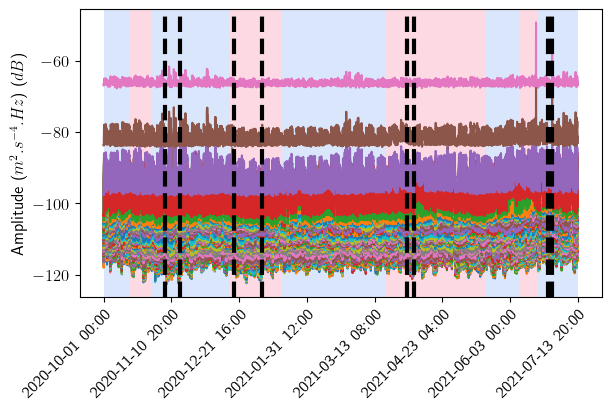

In [21]:
n_bkps = len(true_bkps) - 1

pred_bkps = fit_predict(
    signal=signal,
    cost_name=COST_NAME,
    n_bkps=n_bkps
)

results_scores = evaluate(
    true_bkps,
    pred_bkps,
    margin=10*24  # 10 days
)
print(results_scores)

plot_bkps(
    signal=signal,
    true_bkps=true_bkps,
    pred_bkps=pred_bkps,
    datelist=datelist,
    savefig=False
)

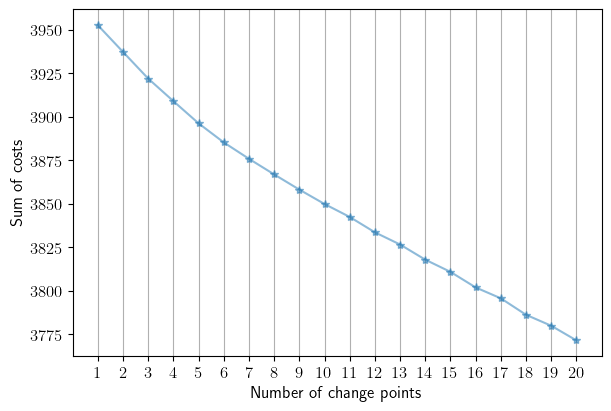

In [22]:
n_bkps_max = 20

array_of_n_bkps, array_of_costs = elbow_method(
    signal=signal,
    cost_name=COST_NAME,
    n_bkps_max=n_bkps_max
)

plot_elbow(
    array_of_n_bkps=array_of_n_bkps,
    array_of_costs=array_of_costs,
    savefig=False
)

{'precision-recall': (0.6666666666666666, 0.5), 'hausdorff': 1588.0, 'randindex': 0.8110946863132497}


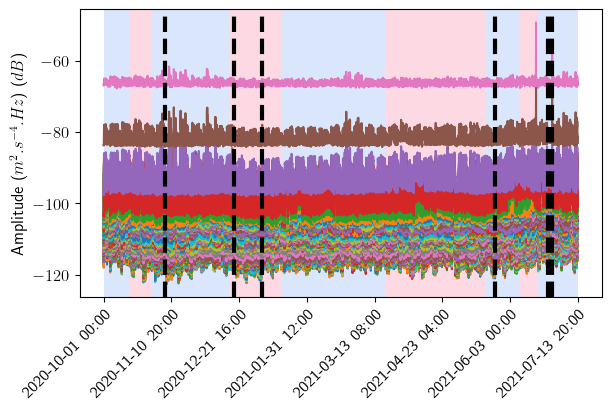

In [23]:
pen = 10

pred_bkps = fit_predict(
    signal=signal,
    cost_name=COST_NAME,
    pen=pen
)

results_scores = evaluate(
    true_bkps,
    pred_bkps,
    margin=10*24  # 10 days
)
print(results_scores)

plot_bkps(
    signal=signal,
    true_bkps=true_bkps,
    pred_bkps=pred_bkps,
    datelist=datelist,
    savefig=False
)

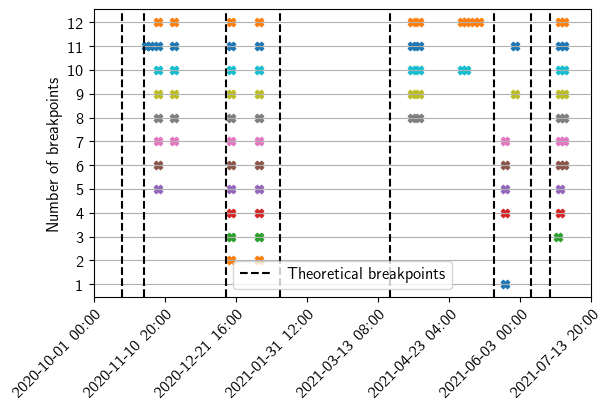

In [24]:
n_bkps_max = 12

array_of_n_bkps, list_of_bkps = dp_bkps(
    signal=signal,
    cost_name=COST_NAME,
    n_bkps_max=n_bkps_max
)

plot_dp(
    true_bkps,
    list_of_bkps,
    datelist=datelist,
    savefig=False
)

---